In [1]:
library(fpp3)

Registered S3 method overwritten by 'tsibble':
  method               from 
  as_tibble.grouped_df dplyr

── Attaching packages ──────────────────────────────────────────── fpp3 1.0.1 ──

✔ tibble      3.2.1     ✔ tsibble     1.1.5
✔ dplyr       1.1.4     ✔ tsibbledata 0.4.1
✔ tidyr       1.3.1     ✔ feasts      0.4.1
✔ lubridate   1.9.3     ✔ fable       0.4.0
✔ ggplot2     3.5.1     

── Conflicts ───────────────────────────────────────────────── fpp3_conflicts ──
✖ lubridate::date()    masks base::date()
✖ dplyr::filter()      masks stats::filter()
✖ tsibble::intersect() masks base::intersect()
✖ tsibble::interval()  masks lubridate::interval()
✖ dplyr::lag()         masks stats::lag()
✖ tsibble::setdiff()   masks base::setdiff()
✖ tsibble::union()     masks base::union()



In [2]:
calendar <- read.csv("data/calendar_afcs2024.csv")
sell_prices <- read.csv("data/sell_prices_afcs2024.csv")
sales_train_validation <- read.csv("data/sales_train_validation_afcs2024.csv")
sales_test_validation <- read.csv("data/sales_test_validation_afcs2024.csv")
sample_submission <- read.csv("data/sample_submission_afcs2024.csv")
sales_test_evaluation <- read.csv("data/sales_test_evaluation_afcs_2024.csv")

# Number of sales

In [3]:
sales_train_validation %>% head()
sales_train_validation %>% tail()

,id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,⋯,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,FOODS_3_001_TX_3_validation,0,2,1,3,0,0,1,0,2,⋯,0,0,0,0,2,0,0,5,2,0
2,FOODS_3_002_TX_3_validation,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
3,FOODS_3_003_TX_3_validation,0,0,0,0,0,0,0,0,0,⋯,1,1,0,0,1,0,0,1,0,0
4,FOODS_3_004_TX_3_validation,0,0,0,0,0,0,0,0,0,⋯,0,0,2,0,0,0,0,0,0,0
5,FOODS_3_005_TX_3_validation,0,1,1,0,0,1,2,0,0,⋯,0,4,2,1,1,0,1,0,4,0
6,FOODS_3_006_TX_3_validation,0,0,0,0,0,0,0,0,0,⋯,0,0,2,1,0,0,1,1,1,0


,id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,⋯,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
818,FOODS_3_822_TX_3_validation,7,5,5,3,0,3,0,1,7,⋯,1,3,2,1,2,0,1,0,1,0
819,FOODS_3_823_TX_3_validation,0,0,0,0,0,0,0,0,0,⋯,1,1,0,1,0,0,0,2,0,2
820,FOODS_3_824_TX_3_validation,0,1,0,1,0,2,0,1,1,⋯,0,0,0,0,0,0,0,0,0,0
821,FOODS_3_825_TX_3_validation,0,0,0,2,1,1,0,0,1,⋯,1,1,1,3,1,0,0,4,2,0
822,FOODS_3_826_TX_3_validation,0,0,0,0,0,0,0,0,0,⋯,0,2,1,1,5,3,1,2,1,2
823,FOODS_3_827_TX_3_validation,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,1,0,1,0,0,3


### Daily average sales

In [4]:
overall_avg_sales <- sales_train_validation %>%
  select(starts_with("d")) %>% 
  summarise(across(everything(), sum, na.rm = TRUE))  # Calculate column-wise mean

overall_avg_sales

Warning message:
"There was 1 warning in `summarise()`.
ℹ In argument: `across(everything(), sum, na.rm = TRUE)`.
Caused by warning:
! The `...` argument of `across()` is deprecated as of dplyr 1.1.0.
Supply arguments directly to `.fns` through an anonymous function instead.

  # Previously
  across(a:b, mean, na.rm = TRUE)

  # Now
  across(a:b, \(x) mean(x, na.rm = TRUE))"


d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,⋯,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1686,1661,1189,1137,954,1598,1107,1680,1660,1263,⋯,1633,1930,2082,1524,1760,1526,1423,1664,1974,1777


In [5]:
# Convert each day column into one row by pivoting
overall_avg_sales <- overall_avg_sales %>%
    pivot_longer(
    cols = starts_with("d"),            
    names_to = "day_code",    
    values_to = "avg_sales"  
  )

overall_avg_sales <- overall_avg_sales %>%
  mutate(
    Date = as.Date("2011-01-29") + as.numeric(sub("d_", "", day_code)) - 1
  )

In [6]:
overall_avg_sales

day_code,avg_sales,Date
<chr>,<int>,<date>
d_1,1686,2011-01-29
d_2,1661,2011-01-30
d_3,1189,2011-01-31
d_4,1137,2011-02-01
d_5,954,2011-02-02
d_6,1598,2011-02-03
d_7,1107,2011-02-04
d_8,1680,2011-02-05
d_9,1660,2011-02-06


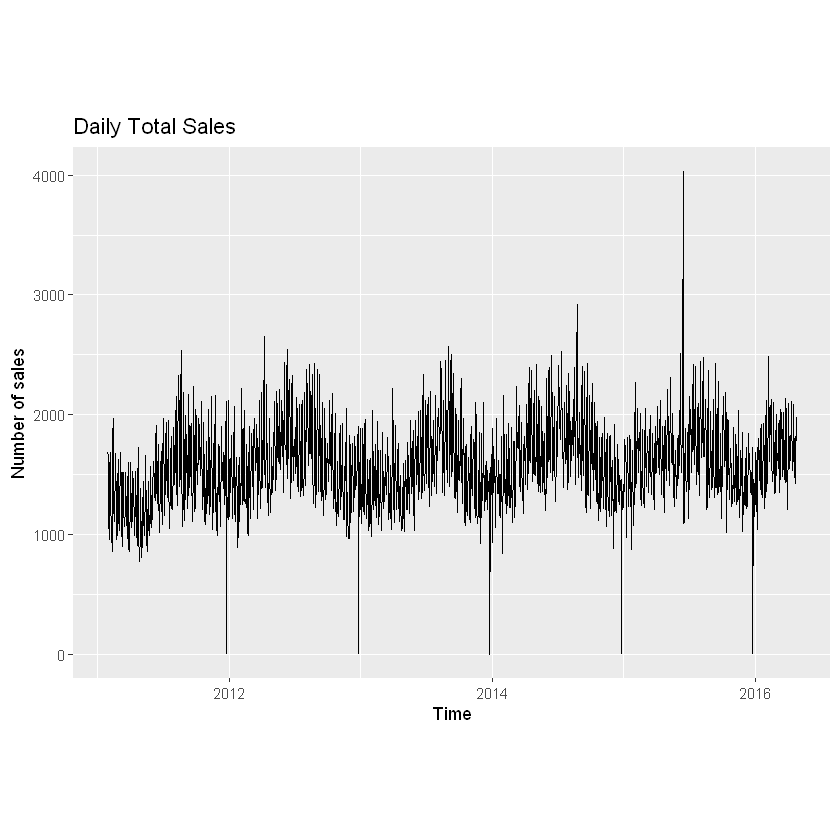

In [7]:
overall_avg_sales %>%
    drop_na(Date) %>%
    as_tsibble(index = Date)%>%
    autoplot(avg_sales) + labs(title = "Daily Total Sales", x = "Time", y = "Number of sales") + theme(aspect.ratio = 0.7)

In [8]:
overall_avg_sales

day_code,avg_sales,Date
<chr>,<int>,<date>
d_1,1686,2011-01-29
d_2,1661,2011-01-30
d_3,1189,2011-01-31
d_4,1137,2011-02-01
d_5,954,2011-02-02
d_6,1598,2011-02-03
d_7,1107,2011-02-04
d_8,1680,2011-02-05
d_9,1660,2011-02-06


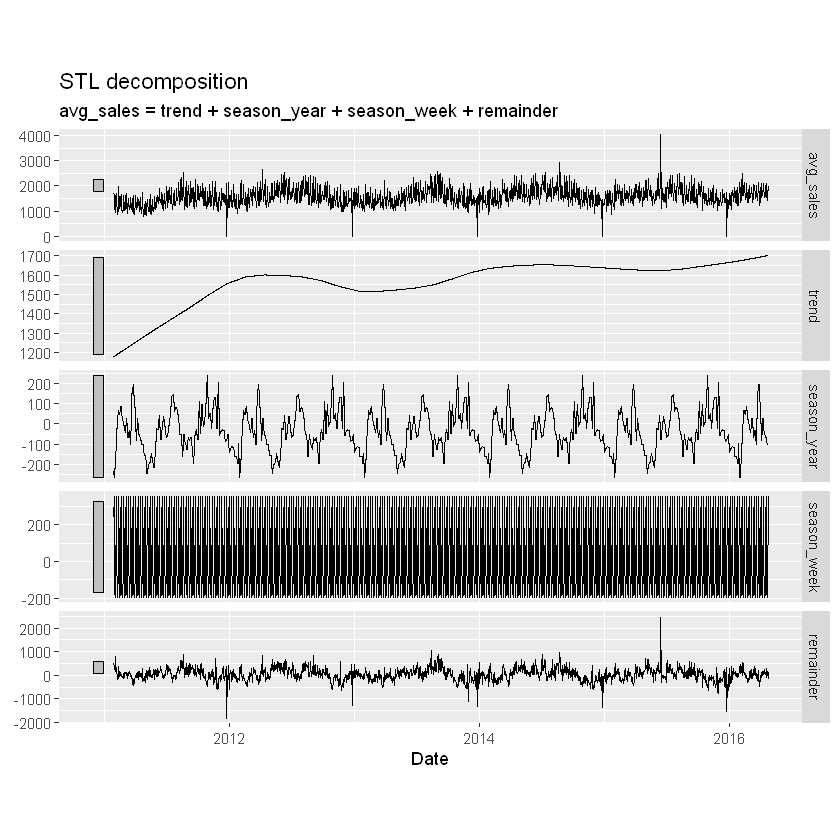

In [9]:
overall_avg_sales %>%
    as_tsibble(index = Date)%>%
    model(STL(avg_sales ~ season(window = "periodic"))) %>%
    components() %>%
    autoplot() + labs(title = "STL decomposition") + theme(aspect.ratio = 0.15)

In [10]:
Sys.setlocale("LC_TIME", "English")

[1] "English_United States.1252"

### Monthly Sales

In [11]:
monthly_overall_avg_sales <- overall_avg_sales %>%
    mutate(YearMonth = yearmonth(Date)) %>%
    group_by(YearMonth) %>%  # Group by Year and Month
    summarise(
        Monthly_Sales = sum(avg_sales, na.rm = TRUE) # Sum up sales
    ) %>%
    as_tsibble(index = YearMonth) %>% # Convert to tsibble
    slice(-1) # We delete first row to being unusually low due data starting the 29tg

In [12]:
monthly_overall_avg_sales

YearMonth,Monthly_Sales
<mth>,<int>
2011 Feb,35702
2011 Mar,36899
2011 Apr,35727
2011 May,35718
2011 Jun,41965
2011 Jul,47161
2011 Aug,50629
2011 Sep,47000
2011 Oct,48812


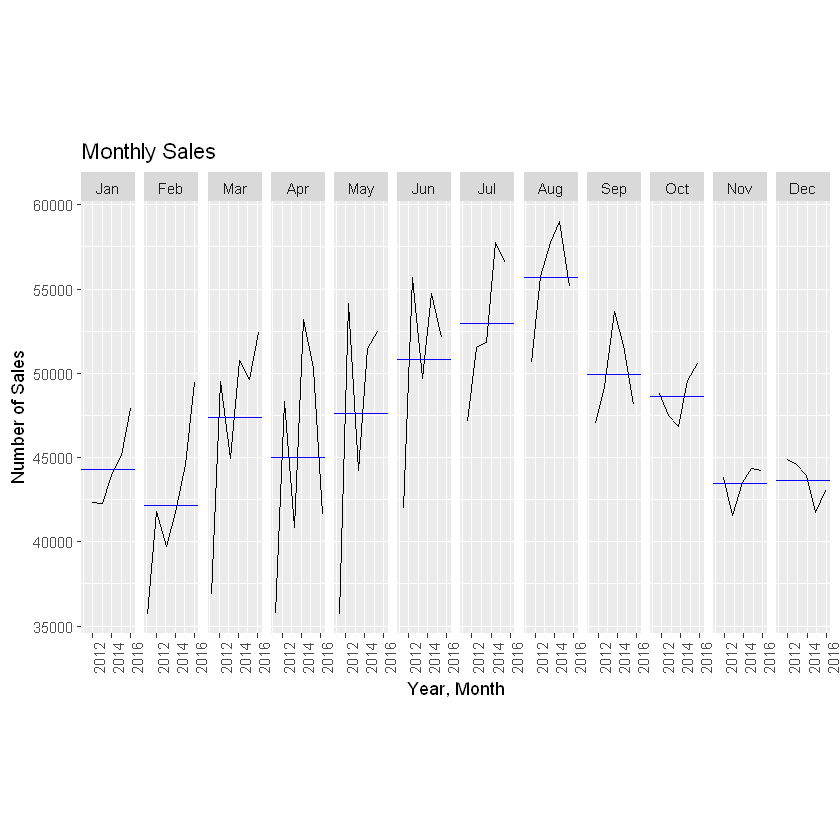

In [13]:
monthly_overall_avg_sales %>% 
    gg_subseries(Monthly_Sales) + labs(title = "Monthly Sales", x = "Year, Month", y = "Number of Sales") + theme(aspect.ratio = 8)

### Most sold product on average

In [15]:
most_selling_product <- sales_train_validation %>%
  rowwise() %>%                                  # Operate on rows
  mutate(avg_sales = mean(c_across(-1), na.rm = TRUE)) %>%  # Calculate average excluding the first column (ID)
  ungroup() %>%                                  # End row-wise operation
  slice_max(avg_sales, n = 1)  
most_selling_product

most_selling_id <- most_selling_product %>%
  select(id)

id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,⋯,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913,avg_sales
<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>
FOODS_3_586_TX_3_validation,115,116,71,66,66,89,78,123,115,⋯,67,69,49,55,60,55,55,66,47,78.47465


In [16]:
# Convert each day column into one row by pivoting
most_selling_product <- most_selling_product %>%
pivot_longer(
    cols = -id,                # Select all columns except the first one (product ID)
    names_to = "day_code",     # Create a new column to store the day codes (d1, d2, etc.)
    values_to = "sales_value"  # Create a new column for sales data
  )

# Add a Date column to `sales_highest`
most_selling_product <- most_selling_product %>%
  mutate(
    Date = as.Date("2011-01-29") + as.numeric(sub("d_", "", day_code)) - 1
  )

Warning message:
"There was 1 warning in `mutate()`.
ℹ In argument: `Date = -...`.
Caused by warning:
! NAs introduced by coercion"


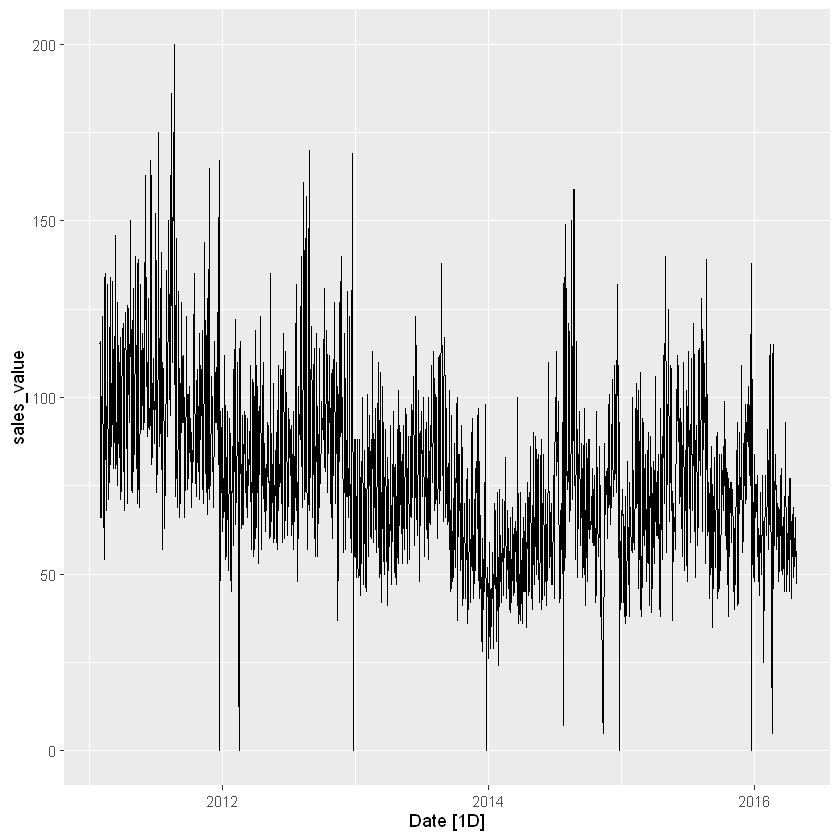

In [17]:
most_selling_product %>%
  drop_na(Date) %>%
  as_tsibble(index = Date) %>%
  autoplot(sales_value)

### Distribution of sales

In [21]:
sales_train_validation$total_sales <- rowSums(sales_train_validation[,grep("d_",colnames(sales_train_validation))])
 sales_train_validation%>%
 select(id,total_sales) %>%
 arrange(desc(total_sales)) %>%
 head(10)

,id,total_sales
,<chr>,<dbl>
1,FOODS_3_586_TX_3_validation,150122
2,FOODS_3_090_TX_3_validation,114854
3,FOODS_3_252_TX_3_validation,86632
4,FOODS_3_555_TX_3_validation,77673
5,FOODS_3_377_TX_3_validation,73797
6,FOODS_3_030_TX_3_validation,47976
7,FOODS_3_202_TX_3_validation,41551
8,FOODS_3_714_TX_3_validation,40650
9,FOODS_3_587_TX_3_validation,40306


In [22]:
sales_stats <- sales_train_validation %>%
    summarise(
        avg_sales = mean(total_sales, na.rm = TRUE),
        max_sales = max(total_sales, na.rm = TRUE),
        min_sales = min(total_sales, na.rm = TRUE),
        product_with_max_sales = id[which.max(total_sales)],
        product_with_min_sales = id[which.min(total_sales)]
    )

sales_stats


avg_sales,max_sales,min_sales,product_with_max_sales,product_with_min_sales
<dbl>,<dbl>,<dbl>,<chr>,<chr>
3642.109,150122,35,FOODS_3_586_TX_3_validation,FOODS_3_171_TX_3_validation


# Price

In [23]:
sell_prices %>% head()
sell_prices %>% tail()

,store_id,item_id,wm_yr_wk,sell_price
,<chr>,<chr>,<int>,<dbl>
1,TX_3,FOODS_3_001,11101,2.28
2,TX_3,FOODS_3_001,11102,2.28
3,TX_3,FOODS_3_001,11103,2.28
4,TX_3,FOODS_3_001,11104,2.28
5,TX_3,FOODS_3_001,11105,2.28
6,TX_3,FOODS_3_001,11106,2.28


,store_id,item_id,wm_yr_wk,sell_price
,<chr>,<chr>,<int>,<dbl>
185255,TX_3,FOODS_3_827,11616,1
185256,TX_3,FOODS_3_827,11617,1
185257,TX_3,FOODS_3_827,11618,1
185258,TX_3,FOODS_3_827,11619,1
185259,TX_3,FOODS_3_827,11620,1
185260,TX_3,FOODS_3_827,11621,1


### General price stats

In [24]:
price_stats <-sell_prices%>%
 group_by(store_id)%>%
 summarize(
    avg_price= mean(sell_price,na.rm=TRUE),
    max_price= max(sell_price,na.rm=TRUE),
    min_price= min(sell_price,na.rm=TRUE)
    )
price_stats

store_id,avg_price,max_price,min_price
<chr>,<dbl>,<dbl>,<dbl>
TX_3,2.849929,19.48,0.02


### Evolution in prices

Warning message:
"There was 1 warning in `mutate()`.
ℹ In argument: `Date = as.Date(paste(Year, Week, 1, sep = "-"), format =
  "%Y-%U-%u")`.
Caused by warning in `strptime()`:
! (0-based) yday 370 in year 2013 is invalid"
Warning message:
"Removed 1 row containing missing values or values outside the scale range
(`geom_line()`)."


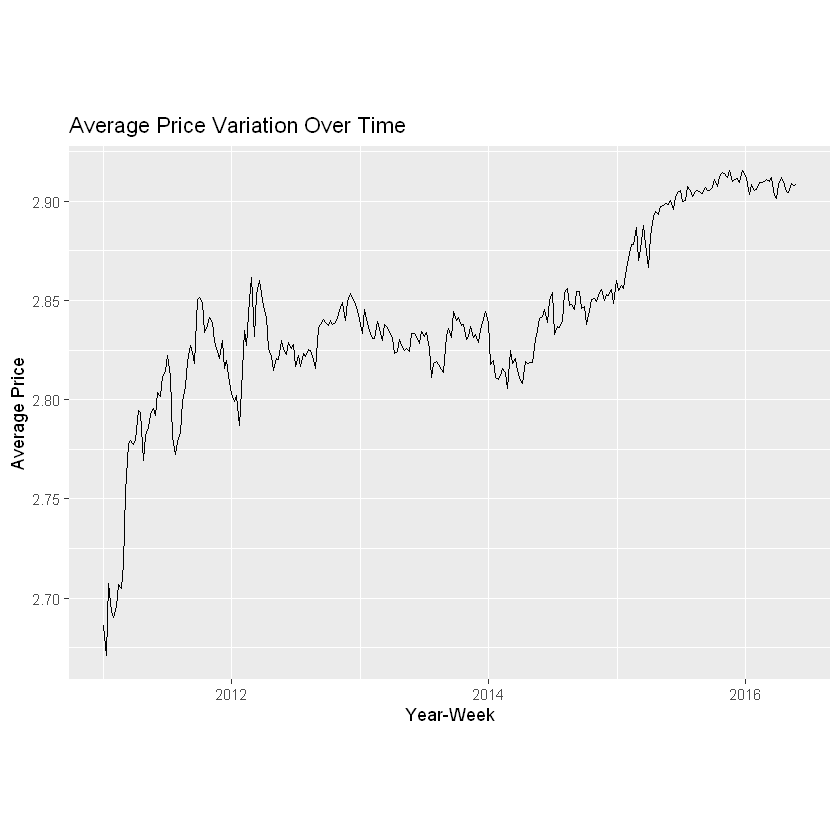

In [25]:
price_per_week <- sell_prices %>%
    group_by(wm_yr_wk) %>%
    summarise(Average_Weekly_Price = mean(sell_price, na.rm = TRUE)) %>%
    mutate(
      Year = floor(wm_yr_wk / 100) + 1900, # Extract year
      Week = wm_yr_wk %% 100,       # Extract week number
      Date = as.Date(paste(Year, Week, 1, sep = "-"), format = "%Y-%U-%u") # Create a Date for the first day of each week
    )

# Plot the average price variation over time
ggplot(price_per_week, aes(x = Date, y = Average_Weekly_Price)) +
  geom_line() +
  labs(title = "Average Price Variation Over Time",
       x = "Year-Week",
       y = "Average Price") + theme(aspect.ratio =  0.7)

### Week with highest price change

Warning message:
"Removed 1 row containing missing values or values outside the scale range
(`geom_line()`)."


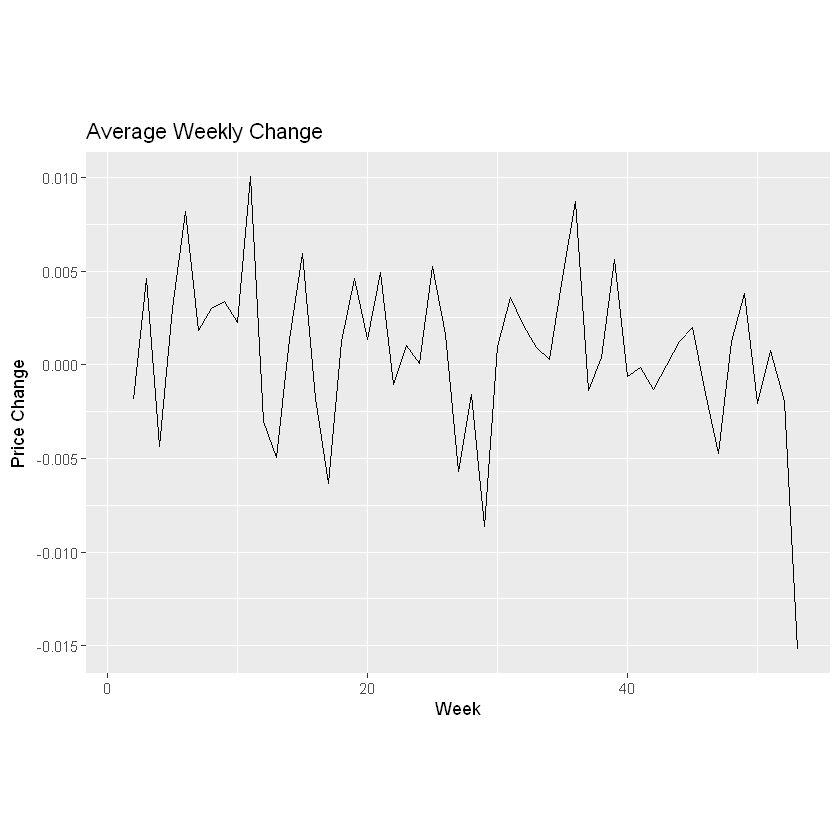

In [26]:
price_change_per_week <- price_per_week %>%
    mutate(Week_Change = Average_Weekly_Price - lag(Average_Weekly_Price)) %>%
    group_by(Week) %>%
    summarise(Average_Change = mean(Week_Change))

price_change_per_week %>%
    as_tsibble(index = Week) %>%
    autoplot(Average_Change) + labs(title = "Average Weekly Change", x = "Week", y = "Price Change") + theme(aspect.ratio = 0.7)

### Price of most selling product

In [27]:
most_selling_id

id
<chr>
FOODS_3_586_TX_3_validation


# Calendar events

In [31]:
calendar

date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_TX
<chr>,<int>,<chr>,<int>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<int>
1/29/2011,11101,Saturday,1,1,2011,NA,NA,NA,NA,0
1/30/2011,11101,Sunday,2,1,2011,NA,NA,NA,NA,0
1/31/2011,11101,Monday,3,1,2011,NA,NA,NA,NA,0
2/1/2011,11101,Tuesday,4,2,2011,NA,NA,NA,NA,1
2/2/2011,11101,Wednesday,5,2,2011,NA,NA,NA,NA,0
2/3/2011,11101,Thursday,6,2,2011,NA,NA,NA,NA,1
2/4/2011,11101,Friday,7,2,2011,NA,NA,NA,NA,0
2/5/2011,11102,Saturday,1,2,2011,NA,NA,NA,NA,1
2/6/2011,11102,Sunday,2,2,2011,SuperBowl,Sporting,NA,NA,1


### Events per day of the week

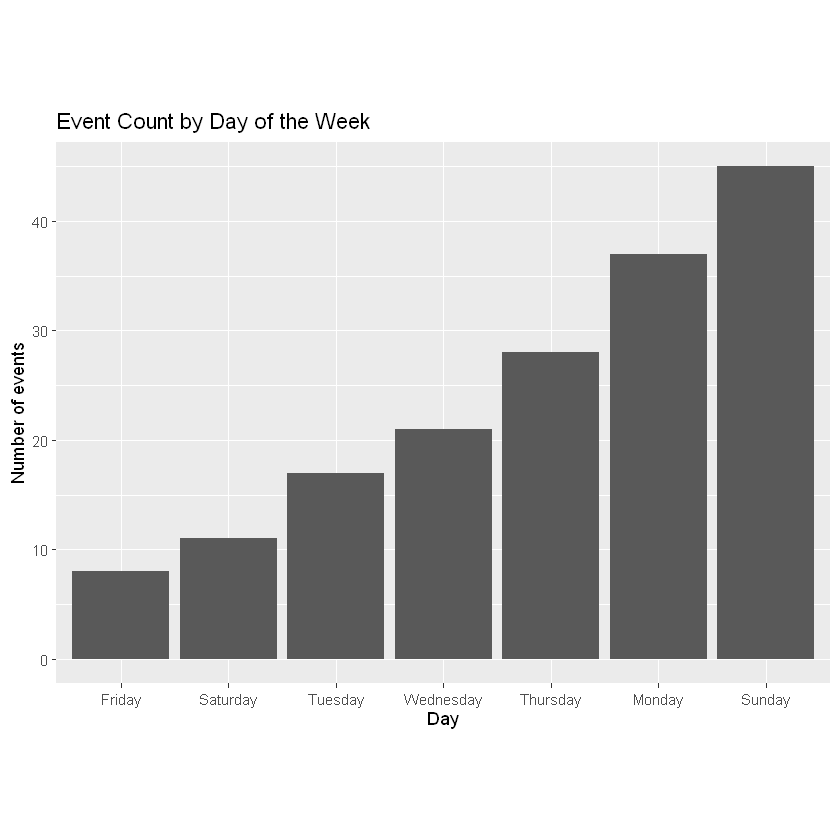

In [32]:
calendar %>%
  group_by(weekday) %>%
  summarise(event_count = sum(!is.na(event_name_1)) + sum(!is.na(event_name_2))) %>% # Count number of days that are not NA in events
  ggplot(aes(x = reorder(weekday, event_count), y = event_count)) + # Order by amount of events
  geom_bar(stat = "identity") +
  labs(title = "Event Count by Day of the Week", x = "Day", y = "Number of events") + theme(aspect.ratio = 0.7)

### Most common types of events

In [40]:
library(knitr)

In [41]:
most_common_events <- calendar %>%
  select(event_type_1, event_type_2) %>%
  pivot_longer(cols = everything(), values_to = "event_type")

In [51]:
# Combine evnt1 and event2 types and sum
most_common_events <- calendar %>%
  select(event_type_1, event_type_2) %>%
  pivot_longer(cols = everything(), values_to = "event_type") %>%
  filter(!is.na(event_type)) %>%
  count(event_type, sort = TRUE) %>%
  mutate(num_events = n) %>%
  select(-n)
most_common_events

# Generate LaTeX code
table_latex <- kable(most_common_events, format = "latex", caption = "Types of events", booktabs = TRUE)

cat(table_latex)

event_type,num_events
<chr>,<int>
Religious,56
National,52
Cultural,41
Sporting,18


\begin{table}

\caption{Types of events}
\centering
\begin{tabular}[t]{lr}
\toprule
event\_type & num\_events\\
\midrule
Religious & 56\\
National & 52\\
Cultural & 41\\
Sporting & 18\\
\bottomrule
\end{tabular}
\end{table}

### Time of year with more events

`summarise()` has grouped output by 'month'. You can override using the
`.groups` argument.


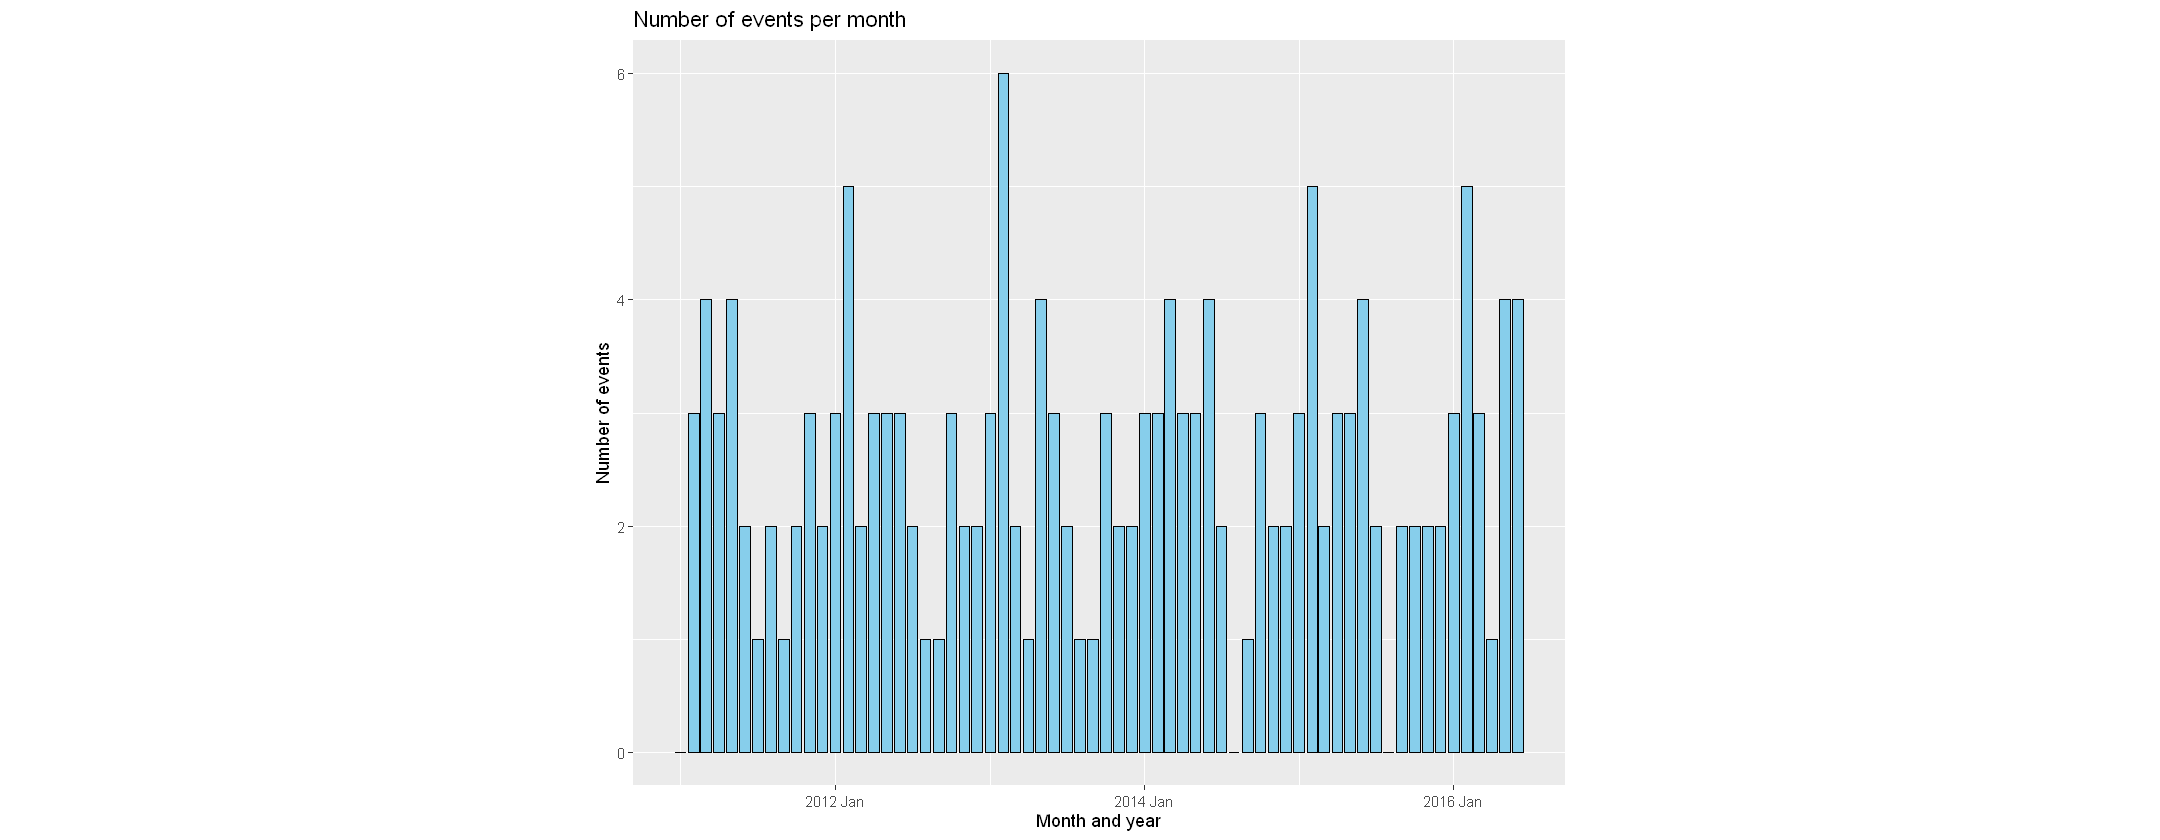

In [60]:
calendar %>%
  mutate(week = wm_yr_wk %% 100) %>%
  group_by(month, year) %>%
  summarise(event_count = sum(!is.na(event_name_1)) + sum(!is.na(event_name_2))) %>%
  mutate(YearMonth = yearmonth(paste(year, month, sep = "-"))) %>%
  as_tsibble(index = YearMonth) %>%
  ggplot(aes(x = YearMonth, y = event_count)) +
  geom_col(fill = "skyblue", color = "black") + 
  theme(aspect.ratio = 0.8) + labs(title = "Number of events per month", x = "Month and year", y = "Number of events")